# Probabilidad de abandono de cliente a productos financieros

Este ejercicio busca clasificar clientes con altas probabilidades de cerrar los productos financiertos con su respectivo banco, basado en un conjunto de datos disponible en [Kaggle](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn) bajo licencia *Community Data License Agreement -- Sharing, Version 1.0*

## Cargue de librerias

In [1]:
import warnings
warnings.filterwarnings('ignore')
import math as mt
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score,accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, 
precision_recall_curve, auc)
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

## Exploracion de datos

In [2]:
#Se realiza lectura inicial del csv y se muestran filas iniciales
df= pd.read_csv(r'Data/Customer-Churn-Records.csv')
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   Point Earned  
0           464  
1           456  
2           377  
3           350  
4           425

Se realiza una primera revision del documento con las observaciones, a continuacion una breve descripcion de los datos:

Las primeras 3 variables (`RowNumber`, `CustomerId`, `Surname`) no se analizaran debido a que son identificadores de fila o numero de cliente (o apellido) que no tienen niguna relacion o dan informacion para con el resultado buscado (probabilidad de que el cliente cancele sus productos bancarios.)
    
| Variable               | Tipo       | Descripcion                                               |
|:-----------------------|:-----------|:----------------------------------------------------------|
| ***CreditScore***      | Discreta   | Puntaje financiero del cliente                            |
| ***Geography***        | Nominal    | Ubicacion del cliente                                     |
| ***Gender***           | Nominal    | Genero de cada cliente                                    |
| ***Age***              | Discreta   | Edad de cada cliente                                      |  
| ***Tenure***           | Discreta   | Cantidad de años del cliente en el banco                  |
| ***Balance***          | Continua   | Saldo del cliente en las cuentas del banco                |
| ***NumOfProducts***    | Discreta   | Numero de productos comprados en el banco                 |
| ***HasCrCard***        | Discreta   | Indica si el cliente tiene o no tarjeta de credito        |
| ***IsActiveMember***   | Discreta   | Indica si el cliente esta activo con el banco             |
| ***EstimatedSalary***  | Continua   | Indica el salario estimado de cada cliente                |
| ***Exited***           | Discreta   | Indica si el cliente salio o no del banco **Variable objetivo**|
| ***Complain***         | Discreta   | Indica si el cliente tiene una queja o no                 |
| ***SatisfactionScore***| Discreta | Puntuacion dada por el cliente por la resolucion de su queja|
| ***CardType***         | Ordinal    | Tipo de tarjeta de cada cliente                           |
| ***PointEarned***      | Discreta   | Puntos obtenidos por el uso de la tarjeta de credito      |









In [3]:
df= df.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Geography           10000 non-null  object 
 2   Gender              10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Exited              10000 non-null  int64  
 11  Complain            10000 non-null  int64  
 12  Satisfaction Score  10000 non-null  int64  
 13  Card Type           10000 non-null  object 
 14  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

Asi pues, el dataset constara inicialmente de 15 columnas, adicionalmente se cuentan con 10.000 observaciones, sin presencia de faltantes en ninguno de los campos.

### Exploracion univariada (variables cuantitativas)

La revision inicial de frecuencias para las variables cuantitativas (discretas y continuas) nos permite empezar a entender el contexto de datos en el que se va a menajar el problema a resolver.

la muestra de datos presenta las siguientes caracteristicas:

1. Principalmente los datos tomandos son de personas jovenes, dado que el 75% de los datos estan concentrados en clientes entre los 18 y 44 años.
2. La antiguedad maxima de los clientes en el banco es de 10 años.
3. Mas del 50% de los clientes tienen salgo en sus productos con el banco que van hasta los 250.898 USD
4. Por lo menos el 50% de los clientes en muestra solo tienen 1 producto con el banco.
5. Por lo menos el 75% de los clientes cuentan con tarjeta de credito.
6. El salario estimado parece de primera vista tner un comportamiendo normal entre 11.5 y 199.992 USD.
7. Menos del 25% tienen algun tipo de queja al banco. 

Frente a nuestra variable a predecir `Exited` se observa un desbalanceo aparente $\pm75\%,25\%$ (no igualdad de datos entre las categorias) de datos debido a que esto corresponde a la cantidad de clientes que no logran ser retenidos por el banco y que debe ser tenido en cuenta al momento de generar modelos de prediccion.

In [4]:
df.describe().T

count           mean           std     min       25%  \
CreditScore         10000.0     650.528800     96.653299  350.00    584.00   
Age                 10000.0      38.921800     10.487806   18.00     32.00   
Tenure              10000.0       5.012800      2.892174    0.00      3.00   
Balance             10000.0   76485.889288  62397.405202    0.00      0.00   
NumOfProducts       10000.0       1.530200      0.581654    1.00      1.00   
HasCrCard           10000.0       0.705500      0.455840    0.00      0.00   
IsActiveMember      10000.0       0.515100      0.499797    0.00      0.00   
EstimatedSalary     10000.0  100090.239881  57510.492818   11.58  51002.11   
Exited              10000.0       0.203800      0.402842    0.00      0.00   
Complain            10000.0       0.204400      0.403283    0.00      0.00   
Satisfaction Score  10000.0       3.013800      1.405919    1.00      2.00   
Point Earned        10000.0     606.515100    225.924839  119.00    410.00   

                           50%          75%        max  
CreditScore            652.000     718.0000     850.00  
Age                     37.000      44.0000      92.00  
Tenure                   5.000       7.0000      10.00  
Balance              97198.540  127644.2400  250898.09  
NumOfProducts            1.000       2.0000       4.00  
HasCrCard                1.000       1.0000       1.00  
IsActiveMember           1.000       1.0000       1.00  
EstimatedSalary     100193.915  149388.2475  199992.48  
Exited                   0.000       0.0000       1.00  
Complain                 0.000       0.0000       1.00  
Satisfaction Score       3.000       4.0000       5.00  
Point Earned           605.000     801.0000    1000.00

In [5]:
atributos= ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned', 'Satisfaction Score']
paleta =  sns.color_palette("pastel")

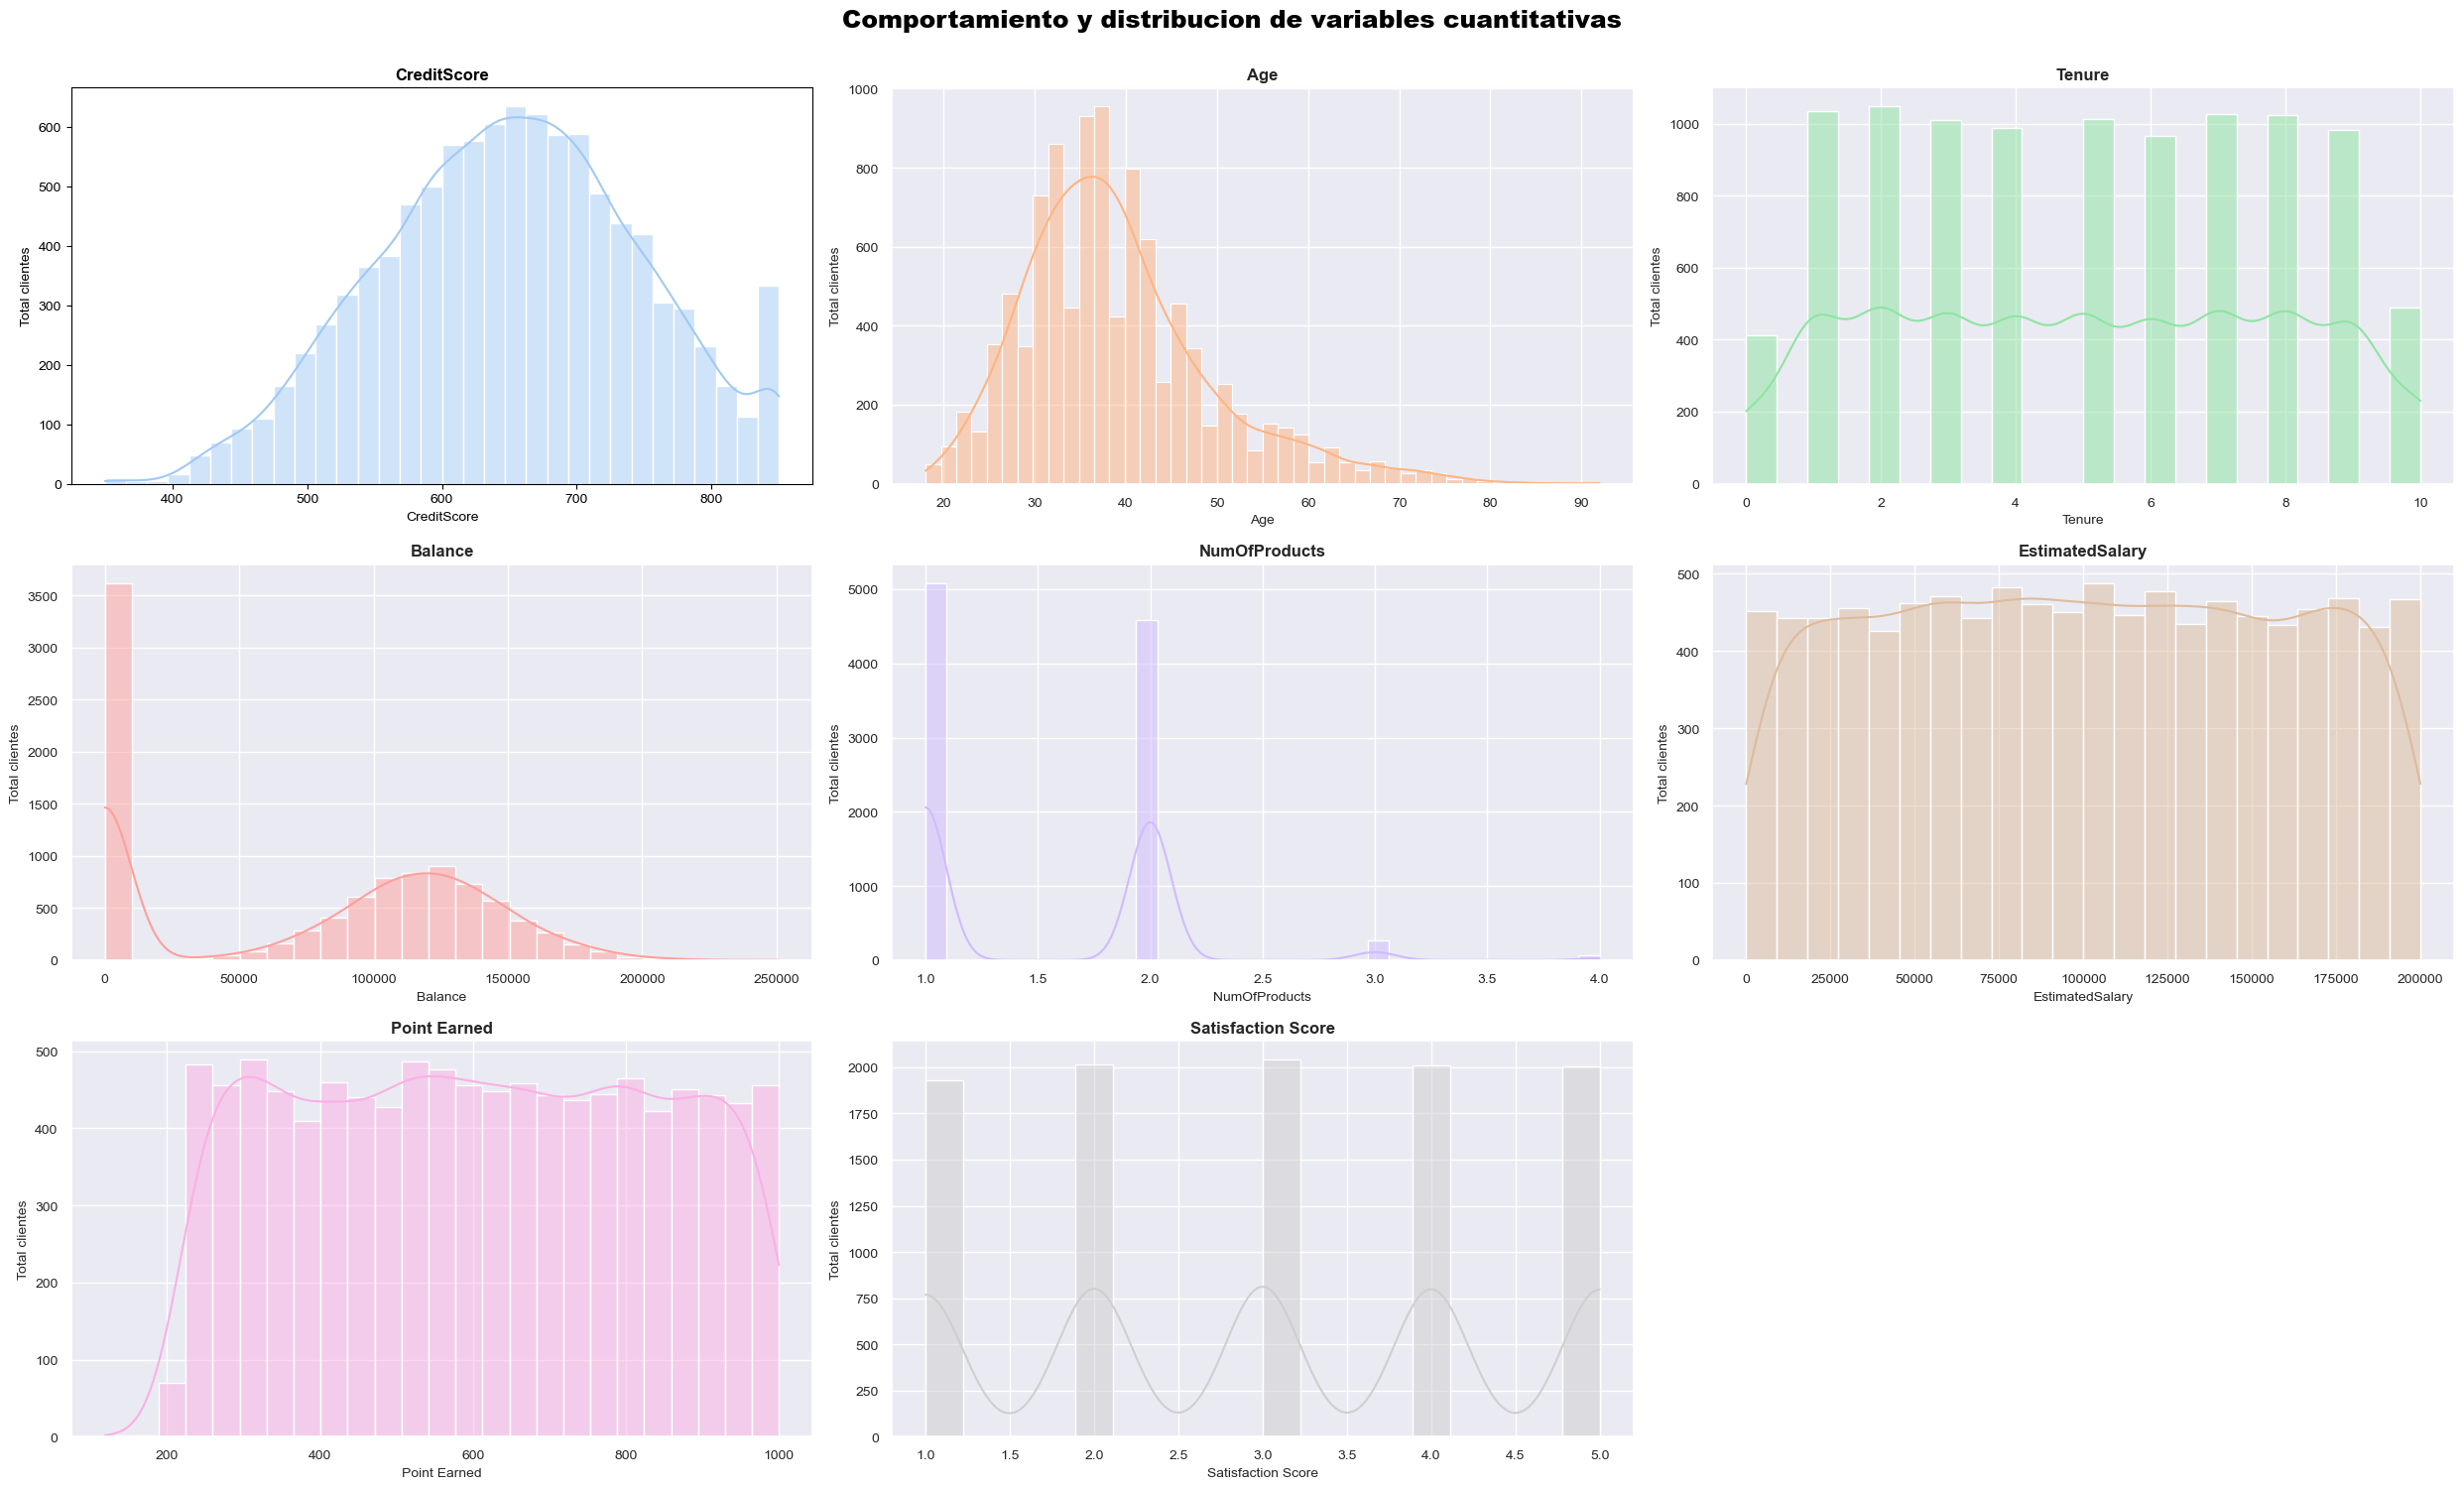

In [6]:
fig= plt.figure(figsize=(25, 15))
fig.suptitle('Comportamiento y distribucion de variables cuantitativas', y= 1, fontweight ="black", fontsize= 18)
for i in range(len(atributos)):
    s= np.std(df[atributos[i]])
    n= len(df[atributos[i]])
    As= 3.5 * s * mt.pow(n, (-1/3))
    k= mt.ceil((max(df[atributos[i]]) - min(df[atributos[i]])) / As)
    #print(k)
    plt.subplot(3,3,1+int(i))
    sns.set_theme(style='darkgrid')
    sns.histplot(df[atributos[i]], kde= True, color= (paleta[i]), bins= k)
    plt.title(atributos[i], fontweight ="bold")
    plt.xlabel(atributos[i], fontsize= 10)
    plt.ylabel('Total clientes', fontsize= 10)
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
fig.tight_layout()
plt.show()

La revision visual del comportamiento de las variables cuantitativas nos dan un poco mas detalle sobre el comportamiento de las mismas:
1. Los clientes de la muetsra tienden a tener puntajes financieros por encima de la media.
2. La poblacion es en su amyoria joven.
3. La antiguedad del cliente no presenta un comportamiento normal, por el contrario asemeja mas el de una distribucion uniforme con baja cantidad de clientes con 1 año de antiguedad o 10 años, lo que puede deberse al metodo de recoleccion de los datos.
4. una gran cantidad de clientes no tiene saldo en sus productos bancarios.
5. El salario estimado al igual que la antiguedad presenta un comportamiento uniforme lo cual es bastante interesante, ya que se tiene la percepcion de que este tipo de variables puede presentar normalmente otro tipo de comportamiento.

In [7]:
for i in range(len(atributos)):
    skewness= stats.skew(df[atributos[i]])
    kurtosis= stats.kurtosis(df[atributos[i]])
    print('------------- {} -------------\nAsimetria: {}\nCurtosis: {}\n'.format(atributos[i], skewness, kurtosis))

------------- CreditScore -------------
Asimetria: -0.07159586676212397
Curtosis: -0.42611279176518124

------------- Age -------------
Asimetria: 1.0111685586628079
Curtosis: 1.3940495456392599

------------- Tenure -------------
Asimetria: 0.010989809189781041
Curtosis: -1.1652426364413717

------------- Balance -------------
Asimetria: -0.14108754375291138
Curtosis: -1.489267106315331

------------- NumOfProducts -------------
Asimetria: 0.745456048438949
Curtosis: 0.5820893733639854

------------- EstimatedSalary -------------
Asimetria: 0.0020850448448748848
Curtosis: -1.181527710874237

------------- Point Earned -------------
Asimetria: 0.008342861313173992
Curtosis: -1.1937841772333617

------------- Satisfaction Score -------------
Asimetria: -0.008934927846710327
Curtosis: -1.2850542627507517



In [8]:
atributos= ['HasCrCard', 'IsActiveMember', 'Complain', 'Exited']
paleta= sns.color_palette("Set2")

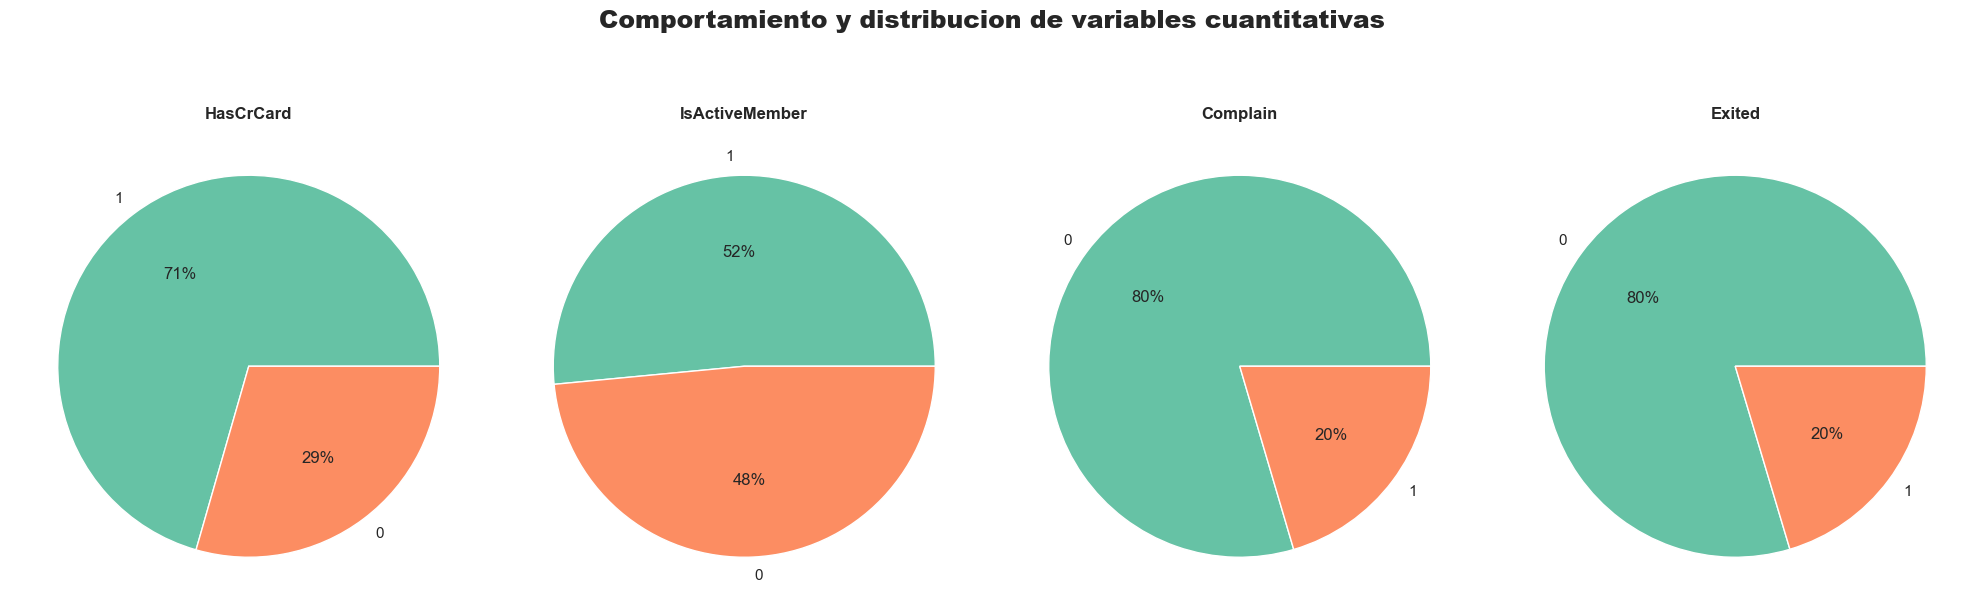

In [9]:
fig= plt.figure(figsize=(20, 8))
fig.suptitle('Comportamiento y distribucion de variables cuantitativas', y= 0.92, fontweight ="black", fontsize= 18)
for i in range(len(atributos)):
    temp= df[atributos[i]].value_counts()
    dic= dict(temp)
    plt.subplot(1, 4, 1+int(i))
    plt.pie(temp, autopct='%.0f%%', labels= dic.keys(), colors= paleta)
    plt.title(atributos[i], fontweight ="bold")
fig.tight_layout()
plt.show()

Frente a las variables booleadas se encuentra que:
1. El 71% de la muestra si tiene tarjeta de credito
2. Cerca de la mitad de los clientes no estan activos.
3. El 80% no han generado ninguna queja al banco

Finalmente el 20% de los clientes han cancelados sus productos, dado que esta clase se enceuntra desbalanceada seria importante aplicar alguna tecnia de remuestreo durante el proceso de modelamiento.

### Exploracion univariada (Variables cualitativas)

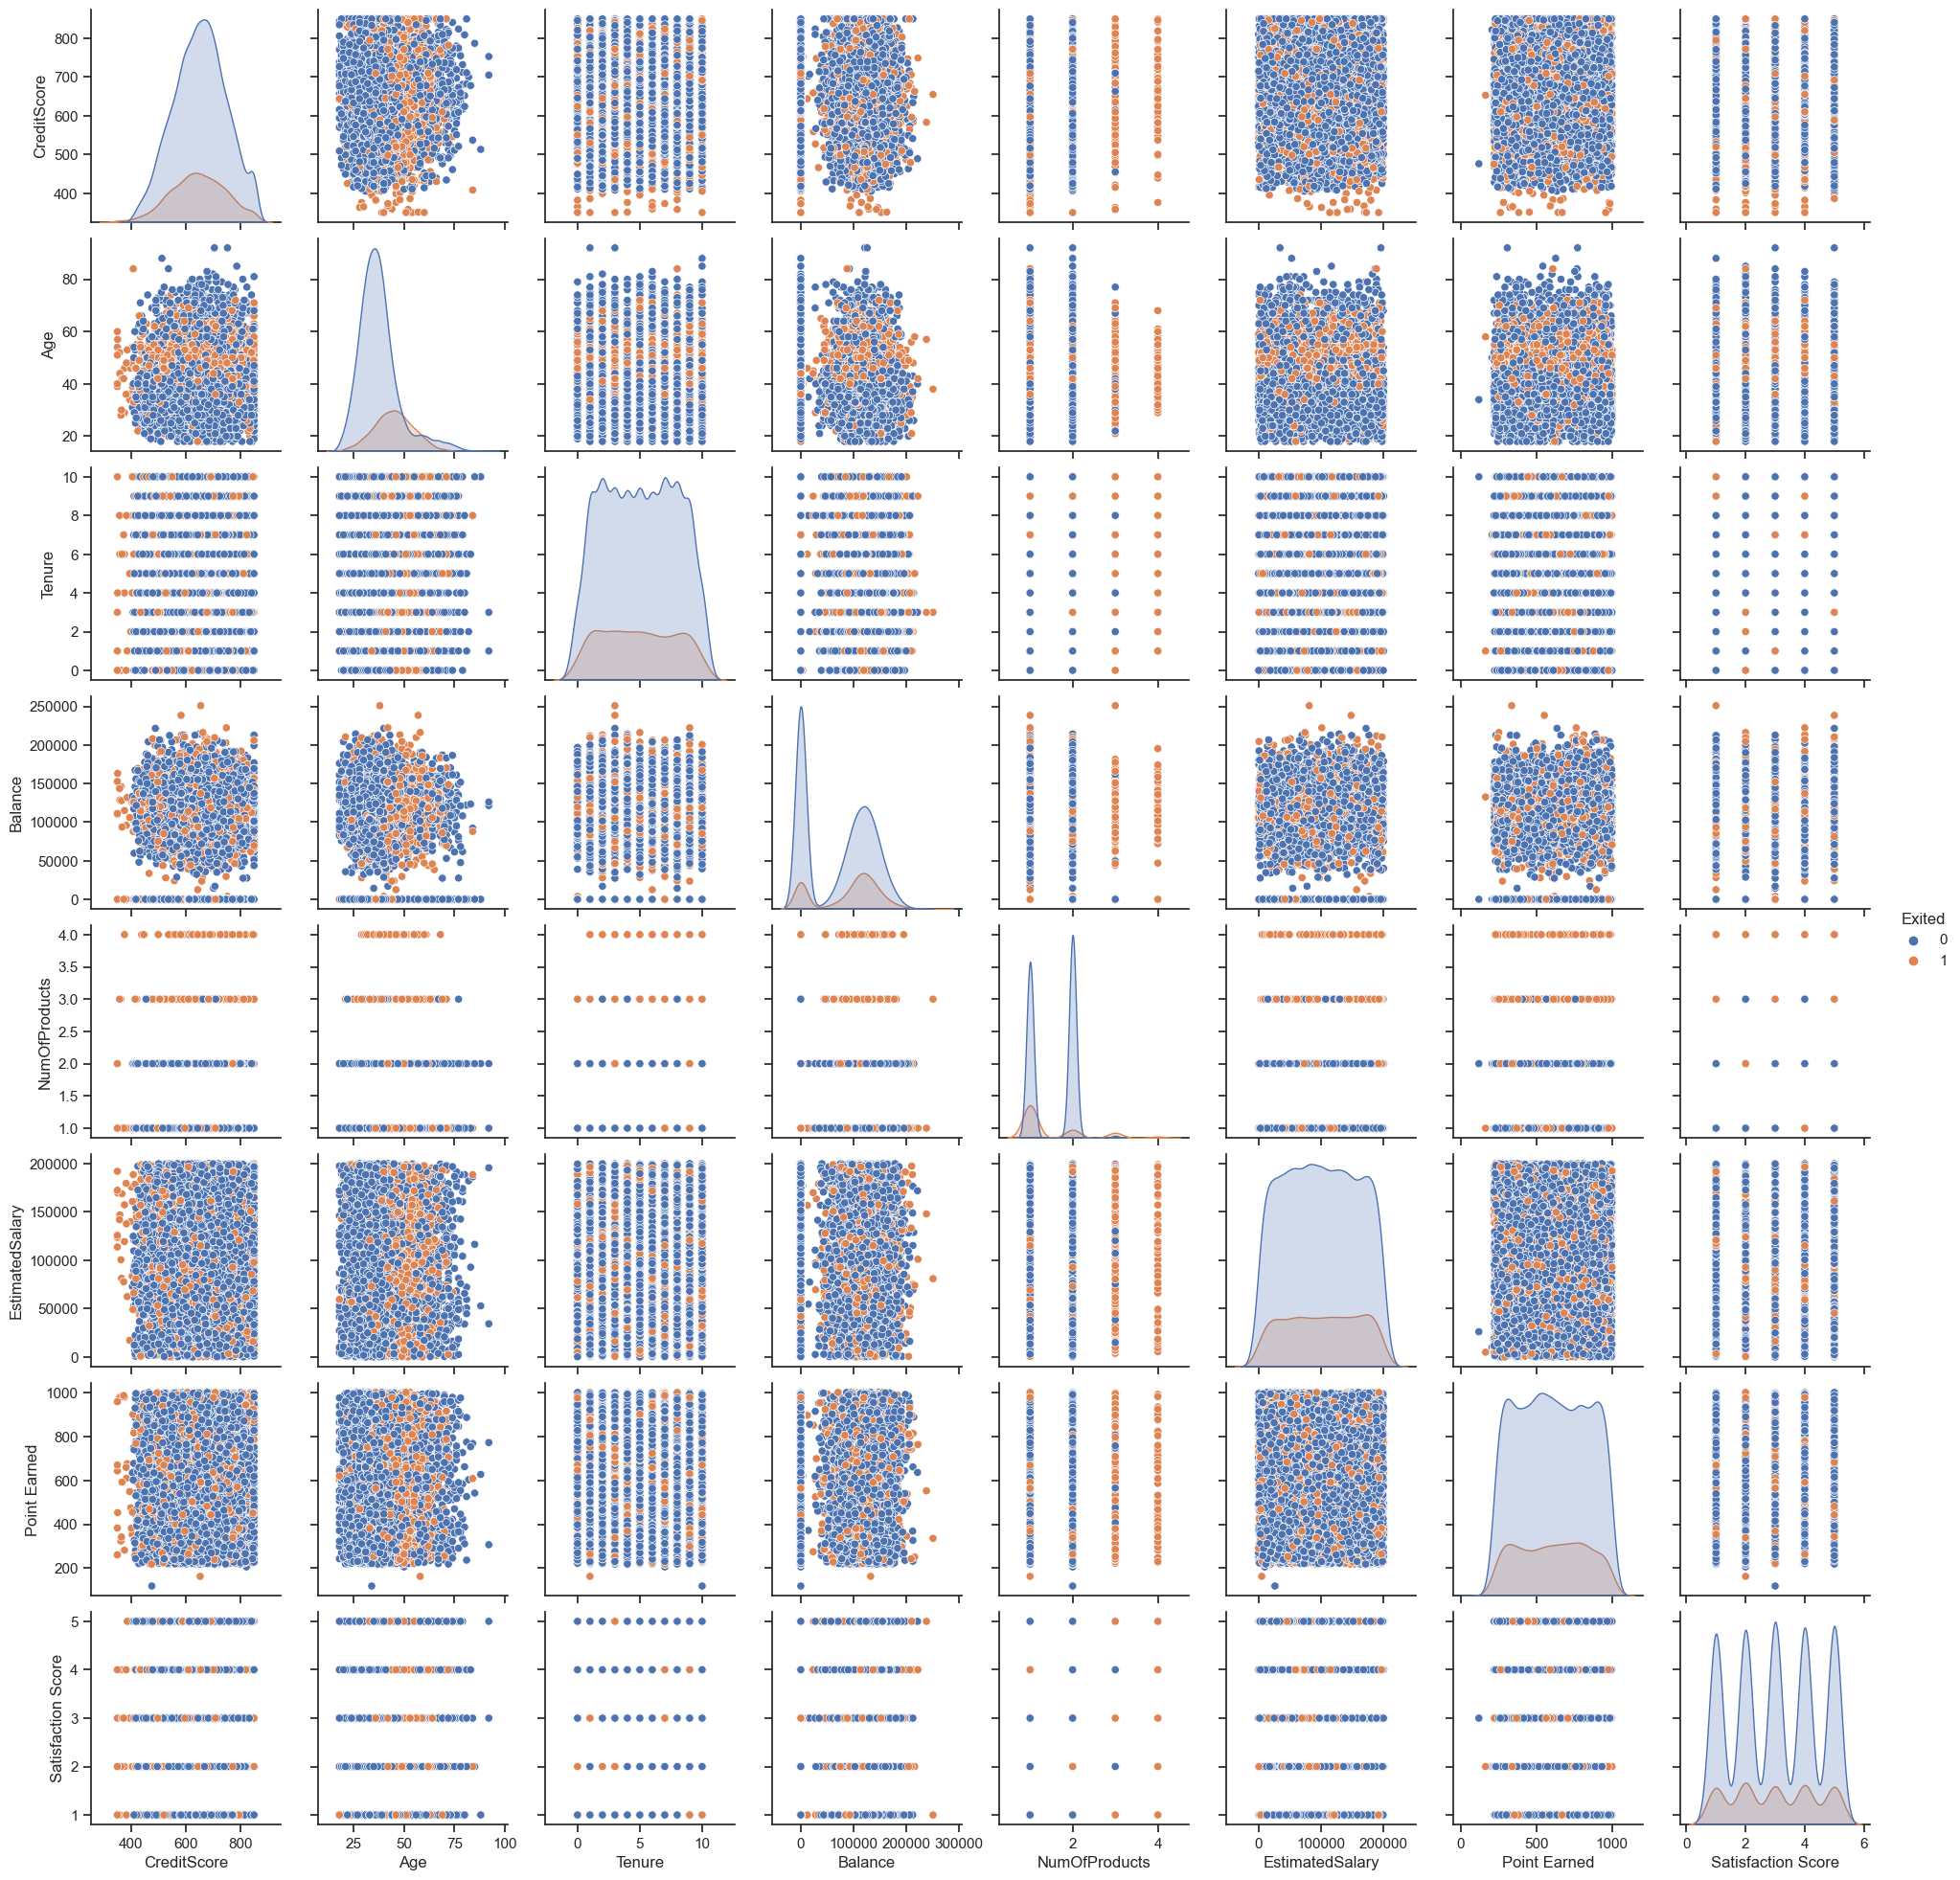

In [10]:
atributos= ['Exited','CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned', 'Satisfaction Score']
sns.set_theme(style="ticks")
sns.pairplot(df[atributos], hue="Exited")

La nube de puntos entre variables escalares y diferenciadas por la categoria del cliente (Salio o no del banco) nos permite ver cosas interesantes.

Como por ejemplo que los clientes son mas estables en el banco antes de los 45 años y despues de 60 años de edad ya que entre estos puntos se observa una gran cantidad de clientes con churn.

Tambien es posible observar como se obseva mayor cantidad clientes con churn cuando estos tienen 3 o 4 productos con el banco 

<Axes: >

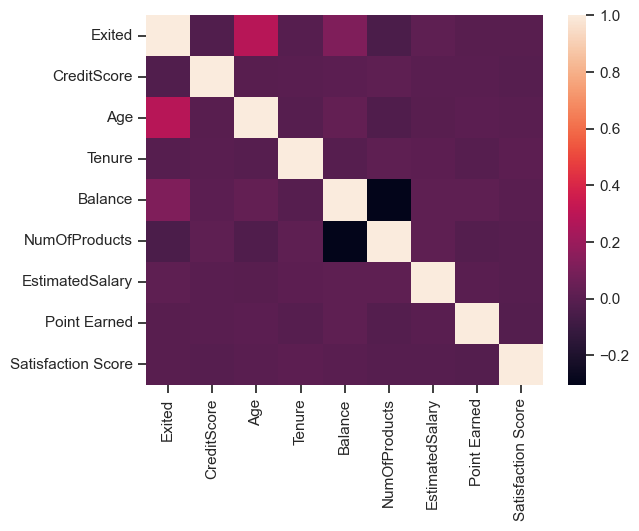

In [11]:
sns.heatmap(df[atributos].corr())

In [12]:
pd.crosstab(df['Gender'], df['Card Type'])

Card Type  DIAMOND  GOLD  PLATINUM  SILVER
Gender                                    
Female        1163  1062      1162    1156
Male          1344  1440      1333    1340

El Analisis de correlacion entre variables escalares nos muestra como la edad y el saldo en productos tienen una correlacion positiva no significativa frente a la variable Churn (Valor a predecir)

## Prepacion de los datos

La preparacion de los datos va a incluir los siguientes pasos:

1. Transformacion en dummy las variables `Geography`, `Gender`
2. Transformacion en variable ordinal la variable `Card Type` 
3. Dado que no hay datos faltes ni presencia de posibles atipicos no se modificara ninguna variable.
4. Creacion de conjuntos de entrenamiento y test

In [13]:
df= pd.get_dummies(df, columns= ['Gender', 'Geography'], drop_first= True)

In [14]:
oe= OrdinalEncoder(categories= [['GOLD', 'PLATINUM', 'SILVER', 'DIAMOND']])
oe.fit(df[['Card Type']])
df['Card Type']= oe.transform(df[['Card Type']])
X= df.drop('Exited', axis=1)
y= df['Exited']

In [15]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42, stratify= y)
X_val, X_test, y_val, y_test= train_test_split(X_test, y_test, test_size= 0.8, random_state= 42, stratify= y_test)

In [16]:
print("Total observaciones de entrenamiento: ", len(X_train))
print("Total observaciones de validacion: ", len(X_test))
print("Total observaciones de test: ", len(X_val))

Total observaciones de entrenamiento:  7000
Total observaciones de validacion:  2400
Total observaciones de test:  600


In [17]:
X_train.head()

CreditScore  Age  Tenure   Balance  NumOfProducts  HasCrCard  \
7680          808   25       7       0.0              2          0   
1837          561   56       7  152759.0              2          1   
2920          696   33       4       0.0              2          1   
2642          637   22       5   98800.0              1          1   
4800          690   39       6       0.0              2          1   

      IsActiveMember  EstimatedSalary  Complain  Satisfaction Score  \
7680               1         23180.37         0                   4   
1837               0        133167.11         1                   2   
2920               1         73371.65         0                   3   
2642               0        122865.55         0                   2   
4800               0        160532.88         0                   1   

      Card Type  Point Earned  Gender_Male  Geography_Germany  Geography_Spain  
7680        0.0           387            1                  0                1  
1837        0.0           377            1                  0                0  
2920        1.0           348            0                  0                0  
2642        2.0           430            0                  0                1  
4800        1.0           517            1                  0                0

## Modelamiento

**Regresion Logistica**

Vamos a iniciar con un ejercicio de modelacion entre dos variables predictoras y el churn de clientes, para explicar el funcionamiento del algoritmo.

In [18]:
X_train_rl= X_train[['Age', 'EstimatedSalary']]
modelo_rl= LogisticRegression(penalty= None)
modelo_rl.fit(X_train_rl, y_train)

LogisticRegression(penalty=None)

In [19]:
print("Intercept:", modelo_rl.intercept_)
print("Coeficiente:", list(zip(X_train_rl.columns, modelo_rl.coef_.flatten(), )))
print("Accuracy de entrenamiento:", modelo_rl.score(X_train_rl, y_train))

Intercept: [-0.00071575]
Coeficiente: [('Age', -0.016418791025366454), ('EstimatedSalary', -5.403704232156736e-06)]
Accuracy de entrenamiento: 0.7961428571428572


In [20]:
balance= dict(round(y_train.value_counts(normalize= True), 2))
odd_base= balance[1] / balance[0]
odd_change= list(modelo_rl.coef_.flatten())
odd_change= list(map(lambda x: mt.exp(x), odd_change))
oddfin= list(map(lambda x: odd_base * x, odd_change))
prob_= list(map(lambda x: x/(1+x), oddfin))
list(zip(X_train_rl.columns, prob_))

[('Age', 0.19738592813001055), ('EstimatedSalary', 0.19999913540872447)]

Lo que se realizo aqui es convertir los Odd ratios y el Odd en probabilidad que facilite la intepretacion; Para el modelo generado el aumentar la edad o el salario, dejando la otra variable estatica, reduce la probabilidad de `Churn` por parte del cliente en un 19% para cualquiera de las dos variables. 

Evaluemos ahora los resultados en los datos de test, para ello primero definimos una funcion que nos permita visualizar todas las metricas necesarias.

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "y--", label="Precision")
    plt.plot(thresholds, recalls[:-1],"g-", label="Recall")
    plt.title('Precision-Recall vs threshold', fontsize=16)
    plt.legend(loc="best", fontsize=12)
    plt.grid(True) 

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.title('Precision-Recall curve', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)    

def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, color='darkorange',linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('Roc curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)  
    
def metricas_test(modelo, X_test, y_test, metodo, threshold):
    t = threshold
    if metodo == 0:
        y_scores = modelo.decision_function(X_test)
    elif metodo ==1:
        y_scores = modelo.predict_proba(X_test)[:,1]
    y_test_pred = np.where(y_scores > t, 1, 0)
    classes = np.unique(y_test)
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    #print(classification_report(y_test, y_test_pred))
    cr= classification_report(y_test, y_test_pred).split('\n')
    fig = plt.figure(figsize=(10,2.5))
    plt.subplot(1,2,1)
    plt.text(0.8, 0, classification_report(y_test, y_test_pred), horizontalalignment= 'right', fontsize= 12,
            fontfamily= 'sans-serif')
    plt.axis('off')
    plt.subplot(1,2,2)
    paleta= sns.color_palette("Blues", as_cmap=True)
    sns.heatmap(cm, annot=True, fmt='d', cmap=paleta, cbar=False).set(
        xlabel="Predicciones", ylabel="Reales", title="Matriz de confusion")
    plt.show()
    precisions, recalls, thresholds = precision_recall_curve (y_test, y_scores)
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1,3,1)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    label=('ROC curve (AUC = %0.2f)' % roc_auc)
    plt.subplot(1,3,2)
    plot_precision_vs_recall(precisions, recalls)
    plt.subplot(1,3,3)
    plot_roc_curve(fpr, tpr, label)
    plt.show()
    lista = []
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = (tp/(tp+fp))
    sensibilidad = (tp/(tp+fn))
    precision_negativos = (tn/(tn+fn))
    especificidad = (tn/(tn+fp))
    f_score = f1_score(y_test,y_test_pred)
    lista+=(accuracy, roc_auc, precision, sensibilidad, precision_negativos, especificidad, f_score)
    return lista    

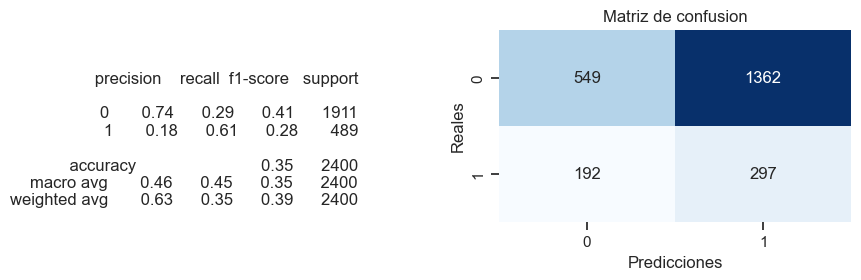

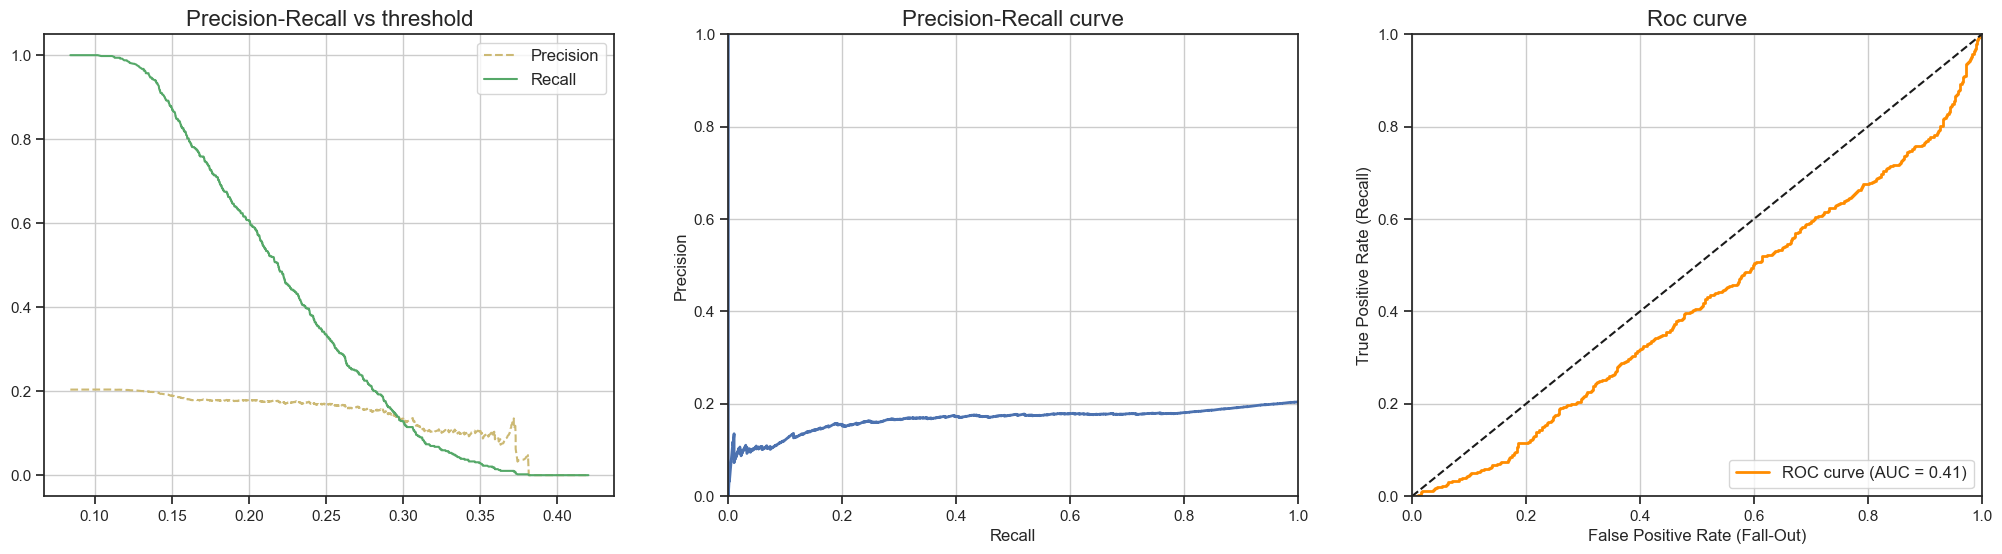

In [22]:
X_test_rl= X_test[['Age', 'EstimatedSalary']]
metricas_rl= metricas_test(modelo_rl, X_test_rl, y_test, 1, 0.2)

Los resultados de este primer modelo, son muy poco alentadores, logrando tener un poder de prediccion peor que el que se pudiera conseguir clasificando al azar, esto puede deberse por lo que se ve en los resultados, al desbalanceo de clases, pues al existir tan pocos casos de la clase  `1` el modelo consigue mejores resultados si clasifica todo como `0`, esto se podra contrarestar añadiendo regularizacion o aplicando tecnicas que permitan balancear mejor las clases. 

In [23]:
modelo_rl1= LogisticRegression(penalty= 'l2')
modelo_rl1.fit(X_train, y_train)

LogisticRegression()

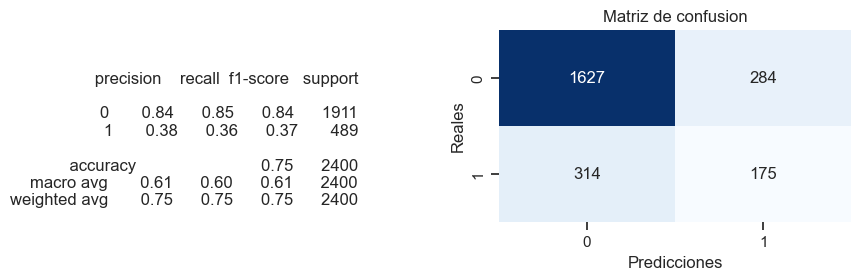

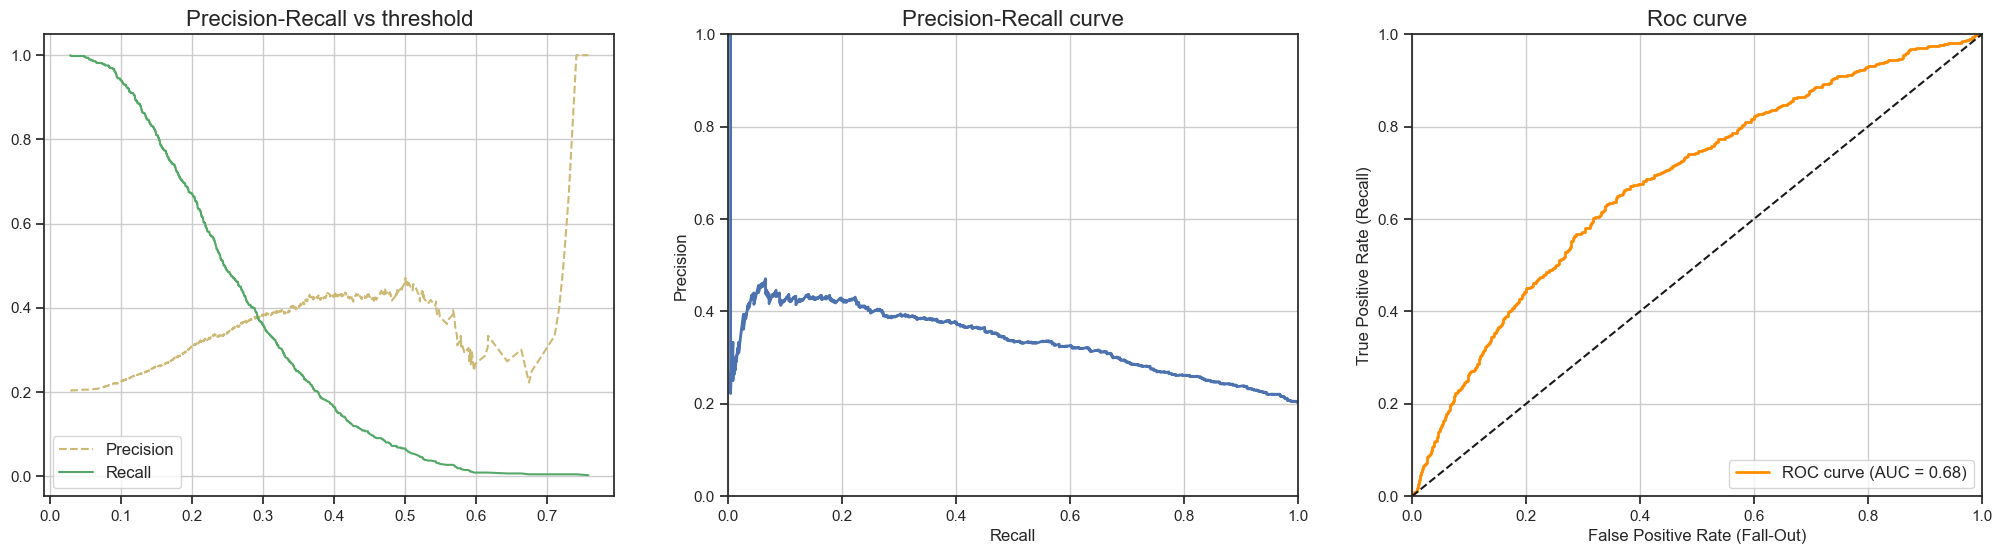

In [24]:
metricas_rl= metricas_test(modelo_rl1, X_test, y_test, 1, 0.3)

Luego de generar un modelo con el total de variables del dataset y penalizacion `l2` se observa como el modelo logra tener un poder de prediccion AUC de 0.7, sin embargo y bajo nuestro ejercicio con un treshold de 0.3 (tomado como la mejor relacion entre precision y recall) aun muestra bastantes errores de clasificacion, ya que de los *305* clientes que slaieron del banco, el modelo solo logro predecir de manera correcta *114* (**recall: 37%**) y adicionalmente bajo este escenario clasifico 117 clientes que no salieron del banco de manera errada (**precision: 39%**)

**KNN**

Para la implementacion de Vecinos cercanos, primero se estandarizan las variables, esto con el fin de que todas tengan la misma incidencia en el resultado de prediccion, y durante la construccion del modelo, se eligen los siguiente hiperparametros:

Vecinos: 21, esto quiere que decir que para la prediccion de cualquier valor nuevo, el modelo tomara los 21 puntos mas cercanos a la observacion a predecir a traves de la distancia euclidea, y de estos se tomara la clase en base a aquella que sea mas comun entre estas observaciones.

In [31]:
X_sc= MinMaxScaler(feature_range=(0, 1))
X_sc.fit(X_train)
X_train = X_sc.transform(X_train)
X_test= X_sc.transform(X_test)

In [ ]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [32]:
modelo_knn= KNeighborsClassifier(n_neighbors= 3, metric= 'minkowski', p= 2)
modelo_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

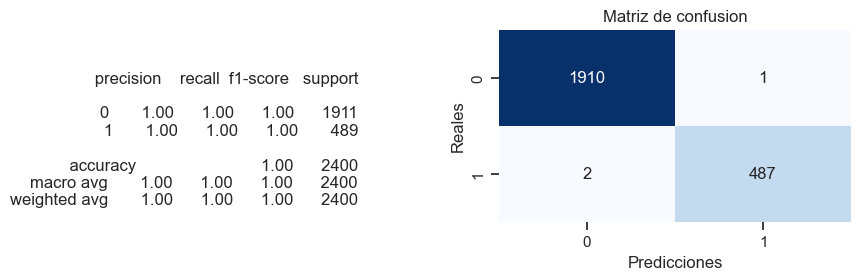

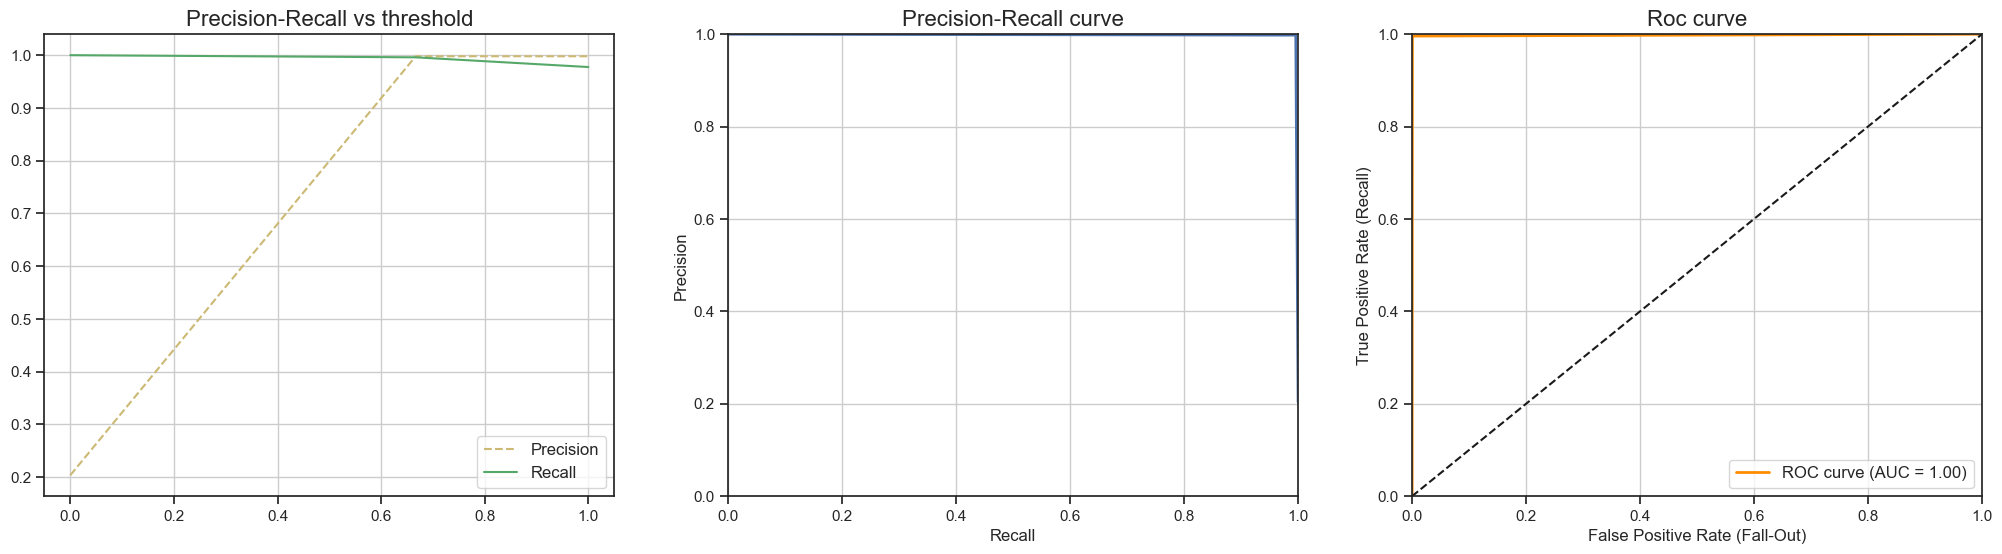

In [33]:
metricas_knn= metricas_test(modelo_knn, X_test, y_test, 1, 0.6)

Aunque parecen resultados exageradamente buenos, los Knn por su forma de funcionamiento, tienden a sobreentrenar los conjuntos en los que se entrebnan por lo que cambios en el ambiente, negocio, o contexto podrian afectar con facilidad la generalizacion del modelo. 

**SVM**

En el siguiente modelo se utilizara una maquina de vectores de soporte usando el truco del kernel radial en busqueda de aumentar las dimensiones de las variables y lograrlas hacer linealmente separables.

In [34]:
modelo_svm= SVC(kernel= 'rbf')
modelo_svm.fit(X_train, y_train)

SVC()

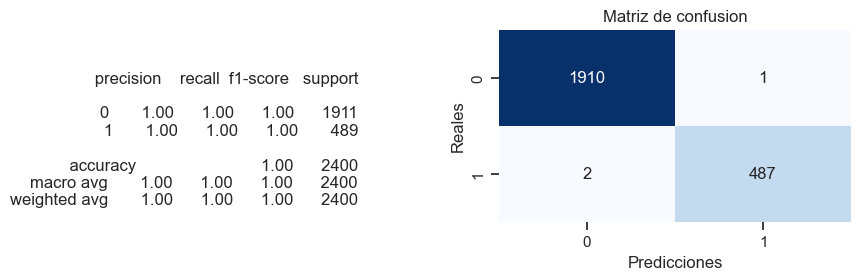

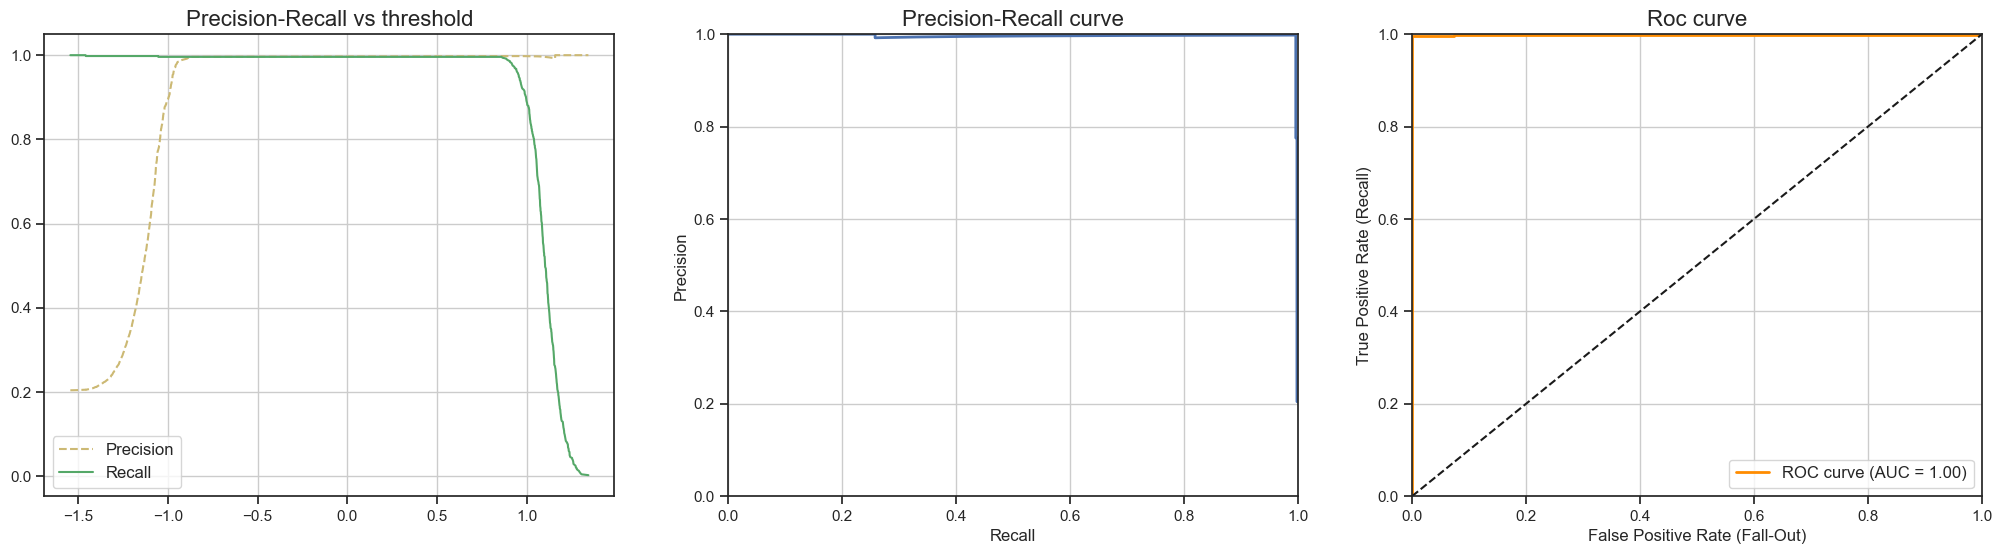

In [35]:
metricas_svm= metricas_test(modelo_svm, X_test, y_test, 0, 0)

**Maximizacion de ganancia**

Para el siguiente ejercicio vamos a tomar como base el modelo de regresion logistica (Suponiendo que es el mejor modelo que se encontro) y del cual se desea estimar el valor optimo del threshold en funcion del negocio.

Para lo anterior, supongamos que cada acierto en la deteccion de un cliente con fuga permite generar ganancias de 1.000 USD anual mientras que cada desacierto genera perdidas de 200 USD esto debido a que vamos a generar estrategias de retencion a un cliente que no pensaba irse del banco.

In [36]:
y_scores = modelo_rl1.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve (y_test, y_scores)

In [37]:
ganancia= pd.DataFrame({'Precisions': precisions[:-1].tolist(),
                        'Recalls': recalls[:-1].tolist(),
                        'Thresholds': thresholds.tolist()})

In [38]:
ganancia['valor'] = ganancia.apply(lambda x: balance[1] * x['Recalls'] * (1000-(200 / x['Precisions'])), axis= 1)

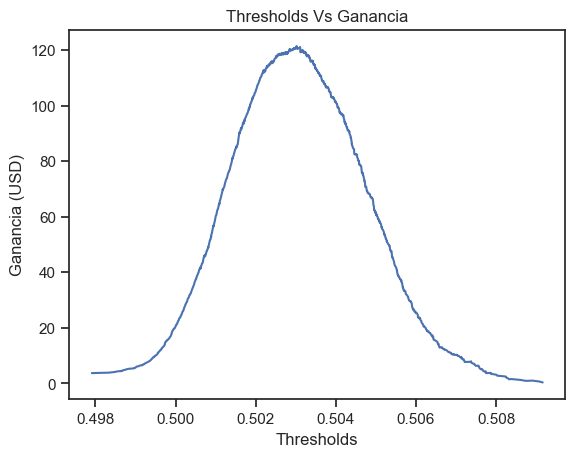

In [47]:
plt.plot(ganancia['Thresholds'], ganancia['valor'])
plt.title('Thresholds Vs Ganancia')
plt.xlabel('Thresholds')
plt.ylabel('Ganancia (USD)')
plt.show()

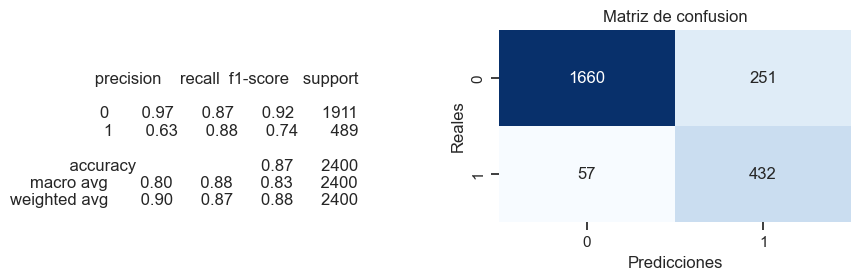

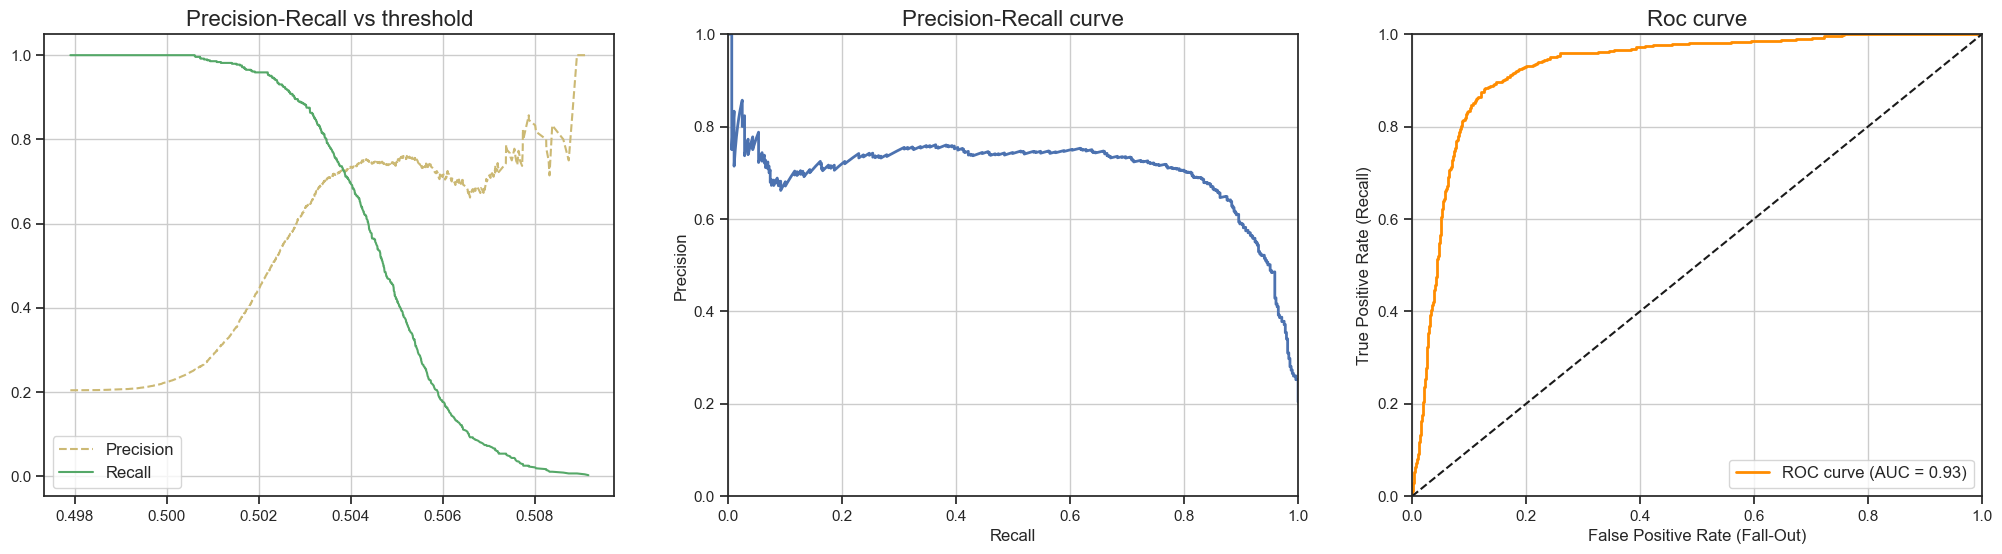

In [45]:
metricas_rl= metricas_test(modelo_rl1, X_test, y_test, 1, 0.503)

Bajo este escenario el punto de corte optimo seria al rededor de 0.503 en donde se consigue encontrar 432 clientes que van a abondar el banco aunque esto implique quiza destinar recursos de retencion a 251 que no vayan a abandonar finalmente el banco, claramente los valores utilizados para el calculo de la funcion de ganancia son fictisios y estan sujetos al modelo de negocio. gracias.